<a href="https://colab.research.google.com/github/akinahomwabella/Data-Imputation/blob/main/Numerical_Analysis_Financial_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  6 of 6 completed
<ipython-input-112-84c33c5c2756>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finance_data['Date'] = pd.to_datetime(finance_data['Date'])


AAPL: ADF p-value = 0.7334 (Stationary: False)
AAPL: Applying transformations for stationarity...
AAPL: Transformed ADF p-value = 0.0000 (Stationary: True)
MSFT: ADF p-value = 0.6918 (Stationary: False)
MSFT: Applying transformations for stationarity...
MSFT: Transformed ADF p-value = 0.0000 (Stationary: True)
GOOG: ADF p-value = 0.5156 (Stationary: False)
GOOG: Applying transformations for stationarity...
GOOG: Transformed ADF p-value = 0.0000 (Stationary: True)
AMZN: ADF p-value = 0.6098 (Stationary: False)
AMZN: Applying transformations for stationarity...
AMZN: Transformed ADF p-value = 0.0000 (Stationary: True)
TSLA: ADF p-value = 0.0238 (Stationary: True)
META: ADF p-value = 0.9754 (Stationary: False)
META: Applying transformations for stationarity...
META: Transformed ADF p-value = 0.0000 (Stationary: True)


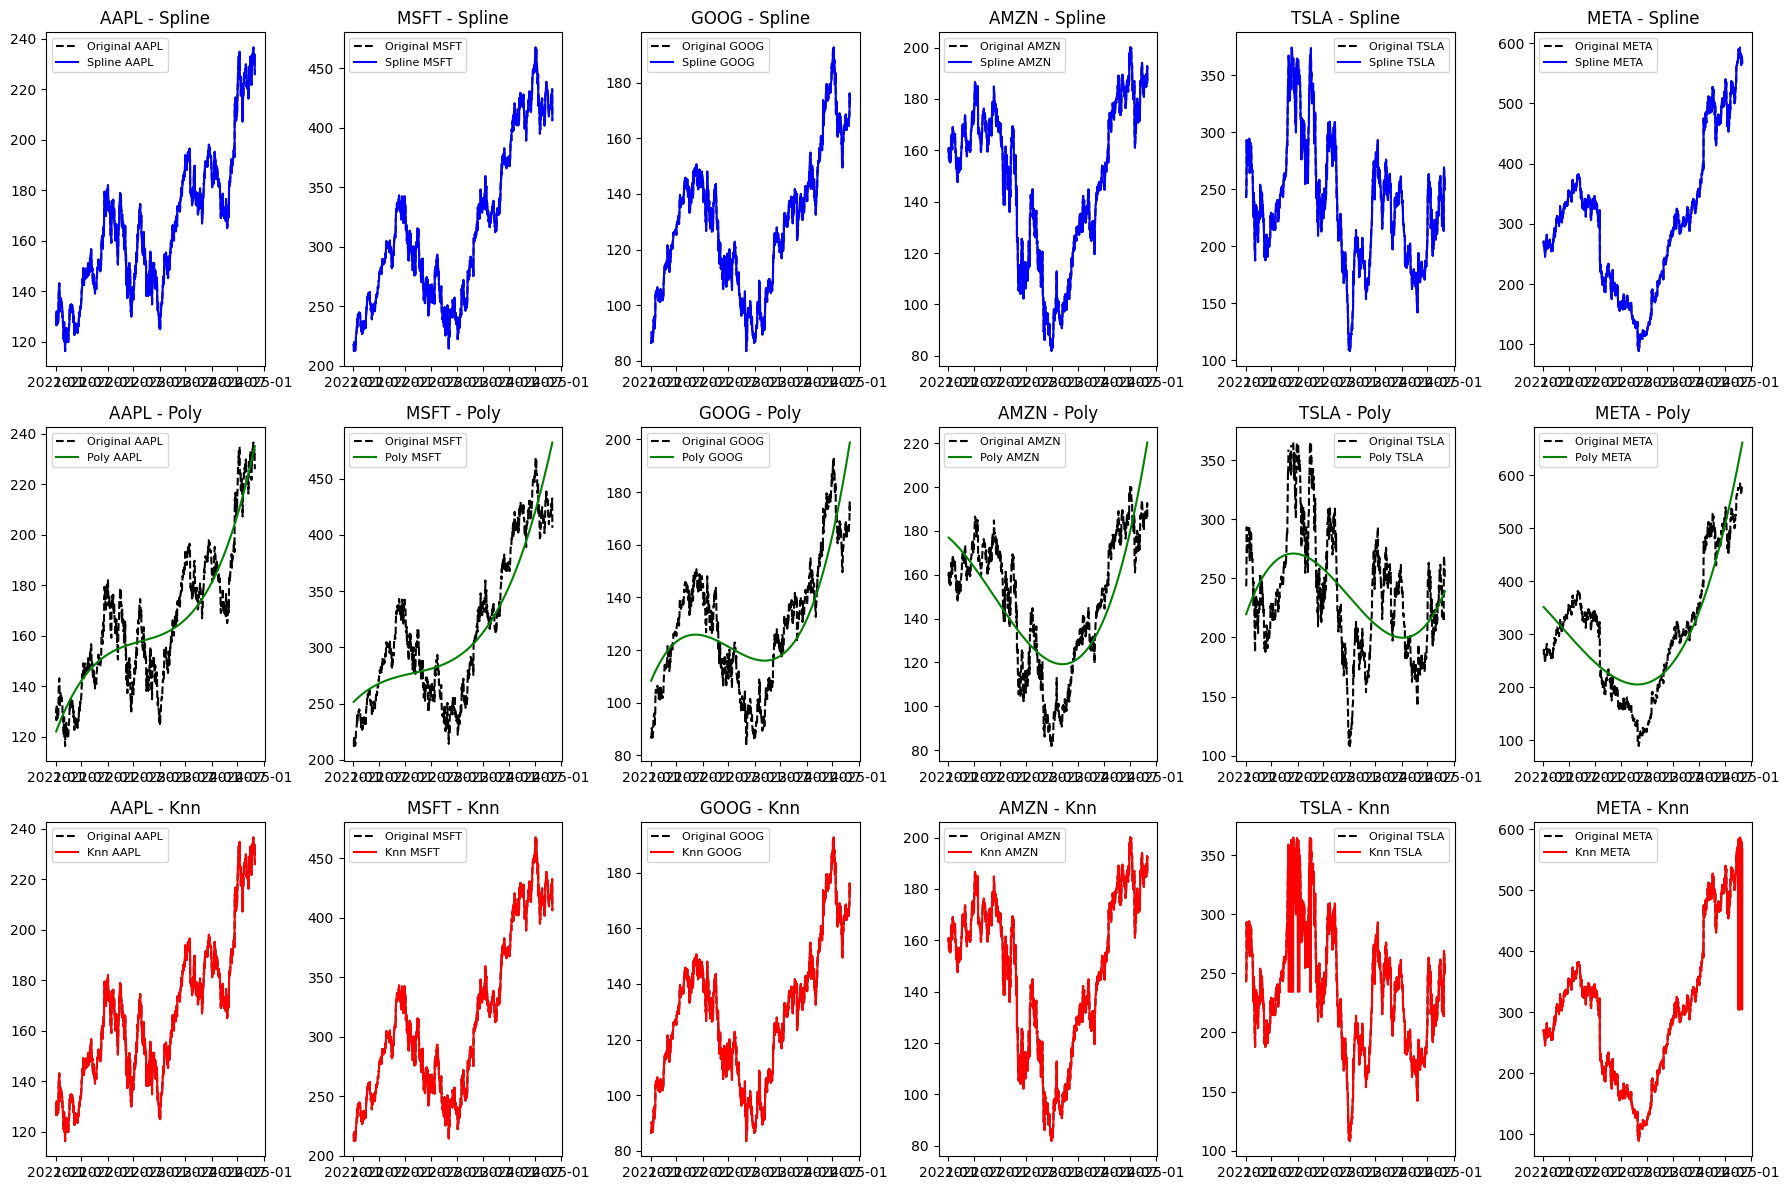

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Step 1: Download financial data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'META']
data = yf.download(tickers, start='2021-01-01', end='2024-11-01', interval='1d')

# Reset the index to make 'Date' a regular column
data.reset_index(inplace=True)

# Flatten the multi-index columns by combining both levels (statistic and ticker)
data.columns = [col[0] if col[1] == '' else f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in data.columns]

# Step 2: Focus on the 'Date', 'Close', and 'Volume' columns for all tickers
close_cols = [col for col in data.columns if 'Close' in col and 'Adj' not in col]
volume_cols = [col for col in data.columns if 'Volume' in col]

# Create a list of selected columns
selected_cols = ['Date'] + close_cols + volume_cols

# Filter the DataFrame to keep only the selected columns
finance_data = data[selected_cols]

# Convert the 'Date' column to datetime
finance_data['Date'] = pd.to_datetime(finance_data['Date'])

# Step 3: Define helper functions

# Outlier Handling using IQR
def remove_outliers_iqr(df, column):
    """Remove outliers based on IQR."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(
        (df[column] < lower_bound) | (df[column] > upper_bound),
        np.nan,
        df[column]
    )
    return df

# Stationarity Check using ADF Test
def check_stationarity(series):
    """Check if a time series is stationary using the ADF test."""
    result = adfuller(series.dropna())  # Ensure no NaN values in the series
    return result[1]  # p-value

# Differencing
def apply_differencing(series, order=1):
    """Apply differencing to make the series stationary."""
    return series.diff(order).dropna()

# Log Transformation
def apply_log_transform(series):
    """Apply log transformation to stabilize variance."""
    return np.log(series + 1)  # Adding 1 to handle zeros

# Spline Interpolation
def spline_interpolation(data, column):
    """Apply spline interpolation to a given column."""
    valid_data = data.dropna(subset=[column])
    spline = interp1d(
        valid_data['Date'].map(pd.Timestamp.toordinal).values,
        valid_data[column].values,
        kind='cubic',
        fill_value="extrapolate"
    )
    data[f'{column}_spline'] = spline(data['Date'].map(pd.Timestamp.toordinal).values)
    return data

# Polynomial Interpolation
def polynomial_interpolation(data, column, degree=3):
    """Apply polynomial interpolation to a given column."""
    valid_data = data.dropna(subset=[column])
    poly_coeff = np.polyfit(
        valid_data['Date'].map(pd.Timestamp.toordinal).values,
        valid_data[column].values,
        deg=degree
    )
    poly_interp = np.poly1d(poly_coeff)
    data[f'{column}_poly'] = poly_interp(data['Date'].map(pd.Timestamp.toordinal).values)
    return data

# KNN Imputation
def knn_imputation(data, column):
    """Apply KNN imputation to a given column."""
    knn_imputer = KNNImputer(n_neighbors=5)
    data[f'{column}_knn'] = knn_imputer.fit_transform(data[[column]])
    return data

# Step 4: Data Cleaning and Imputation
for ticker in tickers:
    # Outlier Removal
    finance_data = remove_outliers_iqr(finance_data.copy(), f'Close_{ticker}')
    finance_data = remove_outliers_iqr(finance_data.copy(), f'Volume_{ticker}')

    # Stationarity Check
    p_value = check_stationarity(finance_data[f'Close_{ticker}'].dropna())
    print(f"{ticker}: ADF p-value = {p_value:.4f} (Stationary: {p_value < 0.05})")
    # If not stationary, apply differencing or log transformation
    if p_value >= 0.05:
        print(f"{ticker}: Applying transformations for stationarity...")
        finance_data[f'Close_{ticker}_transformed'] = apply_differencing(
            apply_log_transform(finance_data[f'Close_{ticker}'])
        )

        # Check stationarity again
        p_value_transformed = check_stationarity(finance_data[f'Close_{ticker}_transformed'].dropna())
        print(f"{ticker}: Transformed ADF p-value = {p_value_transformed:.4f} (Stationary: {p_value_transformed < 0.05})")
    else:
        # Use original data if already stationary
        finance_data[f'Close_{ticker}_transformed'] = finance_data[f'Close_{ticker}']

    # Interpolation Methods
    finance_data = spline_interpolation(finance_data, f'Close_{ticker}')
    finance_data = polynomial_interpolation(finance_data, f'Close_{ticker}')
    finance_data = knn_imputation(finance_data, f'Close_{ticker}')

# Step 5: Visualization
methods = ['spline', 'poly', 'knn']

# Set up the figure size: 3 rows (one for each interpolation method) and 6 columns (one for each ticker)
plt.figure(figsize=(18, 12))

for method_idx, method in enumerate(methods):
    for ticker_idx, ticker in enumerate(tickers):
        plt.subplot(3, 6, method_idx * 6 + ticker_idx + 1)
        plt.plot(
            finance_data['Date'],
            finance_data[f'Close_{ticker}'],
            label=f'Original {ticker}',
            linestyle='--',
            color='black'
        )
        plt.plot(
            finance_data['Date'],
            finance_data[f'Close_{ticker}_{method}'],
            label=f'{method.capitalize()} {ticker}',
            color=['blue', 'green', 'red'][method_idx]
        )
        plt.title(f'{ticker} - {method.capitalize()}')
        plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


Running models for AAPL...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3701.718, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3696.169, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3698.111, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3698.105, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3694.897, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3697.891, Time=0.45 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.400 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  771
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1846.448
Date:                Thu, 05 Dec 2024   AIC                           3694.897
Time:                        09:18:02   BIC                           3699.543
Sample:                             0   HQIC                          3696.685
                                - 771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.0858      0.274     25.886      0.000       6.549 

09:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast (last 5 rows):
            ds        yhat
188 2024-10-25  231.007728
189 2024-10-28  232.165582
190 2024-10-29  232.370685
191 2024-10-30  232.674548
192 2024-10-31  232.937440
Test (last 5 rows):
            ds           y
188 2024-10-25  231.410004
189 2024-10-28  233.399994
190 2024-10-29  233.669998
191 2024-10-30  230.100006
192 2024-10-31  225.910004
Prophet AAPL - MAE: 5.9193, RMSE: 8.0031
Epoch 1/10


<ipython-input-126-0cde43e5d464>:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0514
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0046
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0031
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0026
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0025
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0022
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0022
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0019
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0018
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0018
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
LSTM AAPL - MAE: 5.2396, RMSE: 6.5113


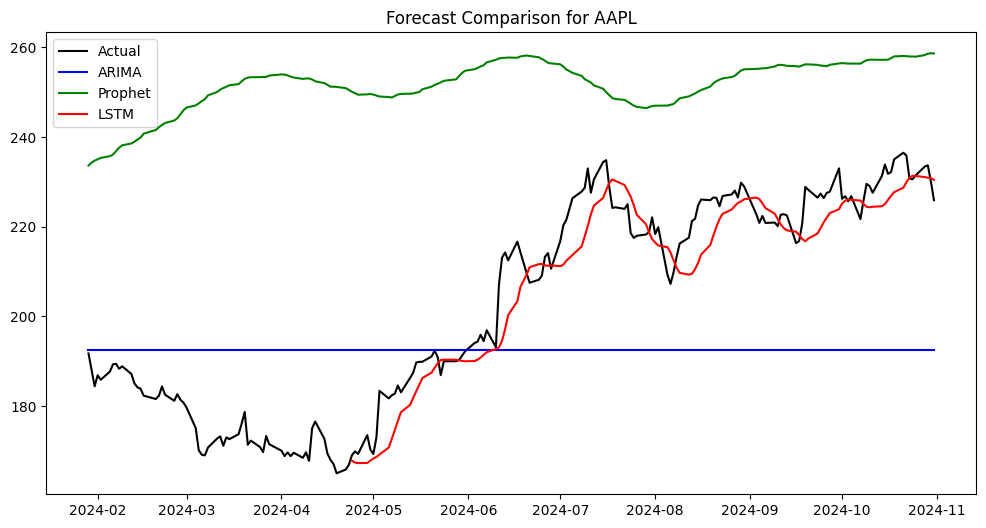

Running models for MSFT...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4615.244, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4616.574, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4617.925, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4617.828, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4616.497, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4618.115, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4617.850, Time=1.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4612.326, Time=1.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4618.410, Time=0.54 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4613.632, Time=6.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4615.892, Time=2.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4612.132, Time=2.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4618.893, Time=0.75 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4618.163, Time=2.57 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA MSFT - MAE: 18.7343, RMSE: 23.6969
Missing values in 'y': 0


09:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast (last 5 rows):
            ds        yhat
188 2024-10-25  421.292807
189 2024-10-28  423.296293
190 2024-10-29  423.719992
191 2024-10-30  424.773984
192 2024-10-31  425.456079
Test (last 5 rows):
            ds           y
188 2024-10-25  428.149994
189 2024-10-28  426.589996
190 2024-10-29  431.950012
191 2024-10-30  432.529999
192 2024-10-31  406.350006
Prophet MSFT - MAE: 9.7485, RMSE: 12.1082
Epoch 1/10


<ipython-input-126-0cde43e5d464>:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0591
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0043
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0023
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0018
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0019
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0016
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0016
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0014
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0013
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0013
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
LSTM MSFT - MAE: 10.7226, RMSE: 13.4042


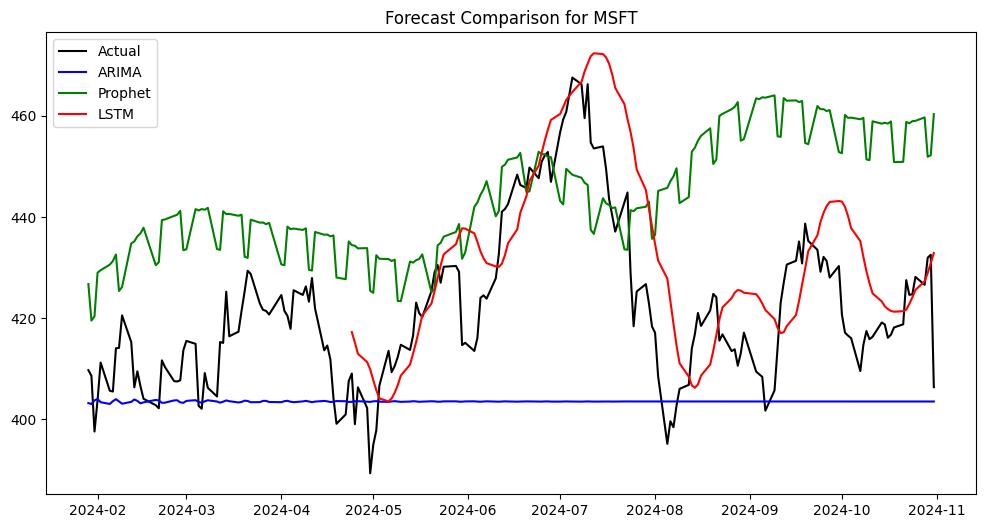

Running models for GOOG...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3477.944, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3473.476, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3475.446, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3475.445, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3472.587, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3474.193, Time=1.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.717 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  771
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1735.293
Date:                Thu, 05 Dec 2024   AIC                           3472.587
Time:                        09:19:29   BIC                           3477.233
Sample:                             0   HQIC                          3474.375
                                - 771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.3088      0.175     30.302      0.000       4.965 

INFO:cmdstanpy:Chain [1] start processing
09:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast (last 5 rows):
            ds        yhat
188 2024-10-25  166.103391
189 2024-10-28  165.453724
190 2024-10-29  165.305037
191 2024-10-30  165.136600
192 2024-10-31  165.072623
Test (last 5 rows):
            ds           y
188 2024-10-25  166.990005
189 2024-10-28  168.339996
190 2024-10-29  171.139999
191 2024-10-30  176.139999
192 2024-10-31  172.690002
Prophet GOOG - MAE: 6.7525, RMSE: 8.0474
Epoch 1/10


<ipython-input-126-0cde43e5d464>:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0490
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0042
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0025
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0022
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0023
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0021
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0020
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0022
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0019
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
LSTM GOOG - MAE: 4.1887, RMSE: 5.5100


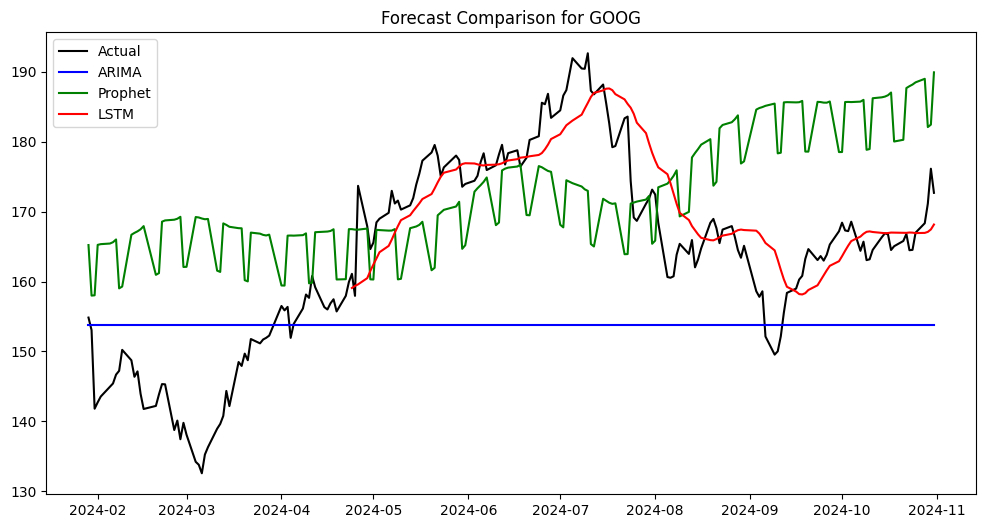

Running models for AMZN...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3914.254, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3907.220, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3909.218, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3909.218, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3905.220, Time=0.04 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3911.218, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.239 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  771
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1951.610
Date:                Thu, 05 Dec 2024   AIC                           3905.220
Time:                        09:19:56   BIC                           3909.867
Sample:                             0   HQIC                          3907.008
                                - 771                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.3114      0.248     37.471      0.000       8.824 

DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68469', 'data', 'file=/tmp/tmp84wn2uhj/h6vq_es6.json', 'init=/tmp/tmp84wn2uhj/iu50d6ts.json', 'output', 'file=/tmp/tmp84wn2uhj/prophet_modelv4co48gr/prophet_model-20241205091956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast (last 5 rows):
            ds        yhat
188 2024-10-25  185.995575
189 2024-10-28  185.994112
190 2024-10-29  185.674639
191 2024-10-30  185.568392
192 2024-10-31  185.556547
Test (last 5 rows):
            ds           y
188 2024-10-25  187.830002
189 2024-10-28  188.389999
190 2024-10-29  190.830002
191 2024-10-30  192.729996
192 2024-10-31  186.399994
Prophet AMZN - MAE: 6.8137, RMSE: 8.7129
Epoch 1/10


<ipython-input-126-0cde43e5d464>:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.1078
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0080
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0046
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0036
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0034
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0036
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0030
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0031
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0029
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0027
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
LSTM AMZN - MAE: 4.8963, RMSE: 6.2064


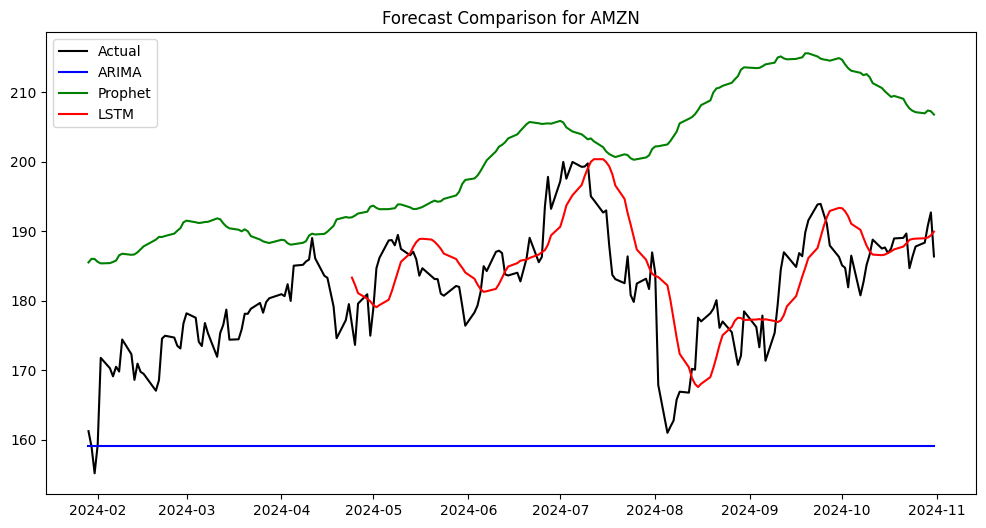

Running models for TSLA...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5428.062, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5422.532, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5423.608, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5423.625, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5420.584, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5424.583, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.263 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2709.292
Date:                Thu, 05 Dec 2024   AIC                           5420.584
Time:                        09:20:25   BIC                           5425.210
Sample:                             0   HQIC                          5422.366
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        76.6373      2.764     27.724      0.000      71.219 

DEBUG:cmdstanpy:input tempfile: /tmp/tmp84wn2uhj/uimwnfrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49436', 'data', 'file=/tmp/tmp84wn2uhj/16u1oh3z.json', 'init=/tmp/tmp84wn2uhj/uimwnfrw.json', 'output', 'file=/tmp/tmp84wn2uhj/prophet_modelf_f2qmx1/prophet_model-20241205092025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast (last 5 rows):
            ds        yhat
188 2024-10-25  222.943295
189 2024-10-28  225.458697
190 2024-10-29  225.974405
191 2024-10-30  226.385124
192 2024-10-31  225.449009
Test (last 5 rows):
            ds           y
188 2024-10-25  269.190002
189 2024-10-28  262.510010
190 2024-10-29  259.519989
191 2024-10-30  257.549988
192 2024-10-31  249.850006
Prophet TSLA - MAE: 15.1156, RMSE: 18.9352
Epoch 1/10


<ipython-input-126-0cde43e5d464>:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.2227
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0160
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0086
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0070
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0066
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0061
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0053
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0048
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0047
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0050
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
LSTM TSLA - MAE: 13.3262, RMSE: 17.4755


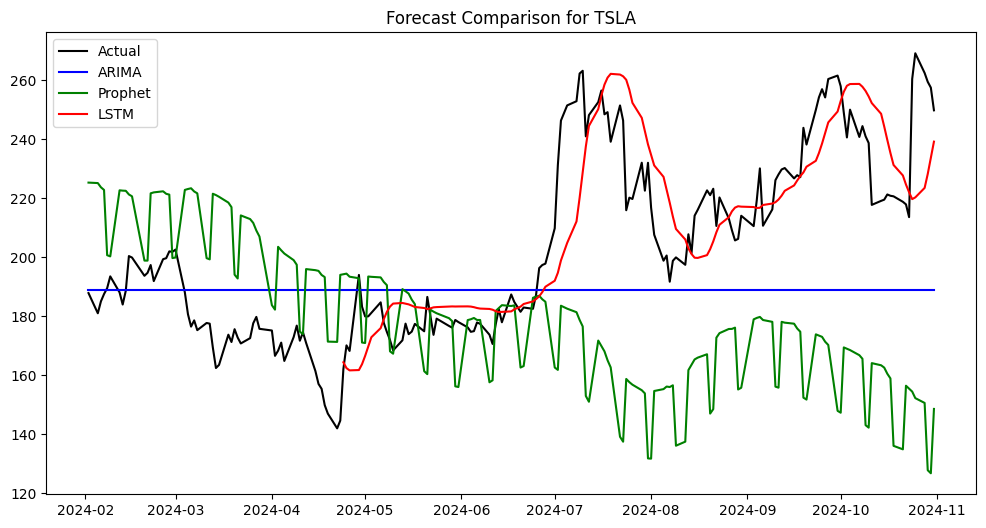

Running models for META...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5086.919, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5080.154, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5081.932, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5081.938, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5078.488, Time=0.03 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5083.830, Time=0.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.529 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  765
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2538.244
Date:                Thu, 05 Dec 2024   AIC                           5078.488
Time:                        09:20:56   BIC                           5083.127
Sample:                             0   HQIC                          5080.274
                                - 765                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        45.0056      0.532     84.622      0.000      43.963 

DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43279', 'data', 'file=/tmp/tmp84wn2uhj/lm5unim9.json', 'init=/tmp/tmp84wn2uhj/y3fyur2_.json', 'output', 'file=/tmp/tmp84wn2uhj/prophet_model1co0r76v/prophet_model-20241205092056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:20:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:20:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast (last 5 rows):
            ds        yhat
188 2024-10-25  548.597806
189 2024-10-28  548.111745
190 2024-10-29  547.367112
191 2024-10-30  547.196354
192 2024-10-31  547.527171
Test (last 5 rows):
            ds           y
188 2024-10-25  573.250000
189 2024-10-28  578.159973
190 2024-10-29  574.633321
191 2024-10-30  571.106669
192 2024-10-31  567.580017
Prophet META - MAE: 26.1384, RMSE: 30.7772
Epoch 1/10


<ipython-input-126-0cde43e5d464>:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0503
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0025
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0010
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.4530e-04
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0010
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 9.3135e-04
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 7.6705e-04
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 9.4130e-04
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 7.2496e-04
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 7.8220e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
LSTM META - MAE: 16.2105, RMSE: 20.6024


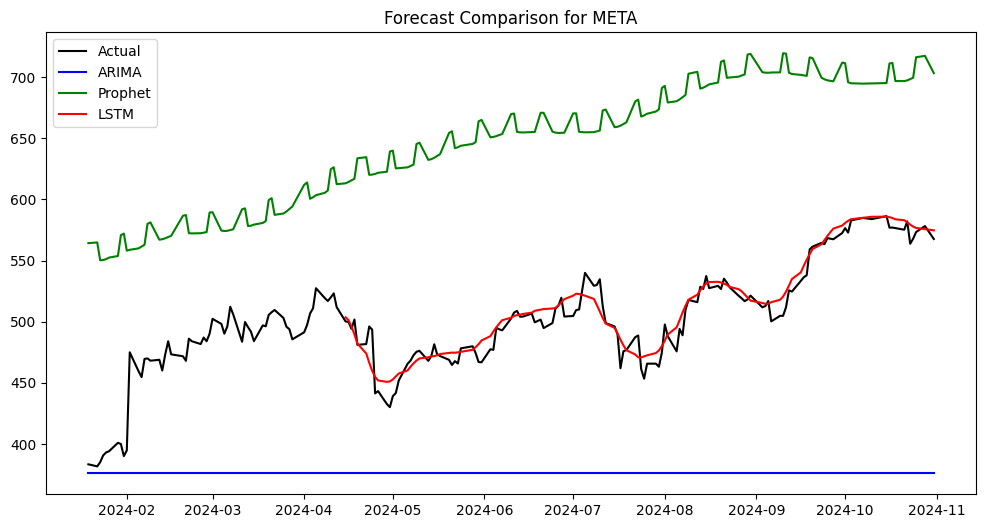

In [ ]:
# Required Libraries
!pip install prophet pmdarima
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense,Input
from keras.optimizers import Adam
import numpy as np

# Ensure finance_data is defined (preprocessing steps included above).

# Auto-ARIMA for parameter selection
def find_best_arima(series):
    auto_model = auto_arima(
        series.dropna(),
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(auto_model.summary())
    return auto_model.order

# ARIMA Forecasting
def arima_forecasting(ticker):
    data = finance_data[['Date', f'Close_{ticker}']].set_index('Date')
    data = data.dropna()  # Ensure no NaN values
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Find optimal ARIMA parameters
    order = find_best_arima(train[f'Close_{ticker}'])

    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Evaluate
    test_values = test.values.flatten()
    mae = np.mean(np.abs(forecast - test_values))
    rmse = np.sqrt(np.mean((forecast - test_values) ** 2))
    print(f'ARIMA {ticker} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    return forecast, test

# Prophet Forecasting
def prophet_forecasting(ticker):
    # Prepare data for Prophet
    data = finance_data[['Date', f'Close_{ticker}']].rename(columns={'Date': 'ds', f'Close_{ticker}': 'y'})
    print(f"Missing values in 'y': {data['y'].isna().sum()}")

    # Handle missing values
    data['y'] = data['y'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    data['ds'] = data['ds'].dt.tz_localize(None)

    # Fit the Prophet model
    model = Prophet()
    model.fit(data)

    # Generate future periods
    train_size = int(len(data) * 0.8)
    future = model.make_future_dataframe(periods=len(data) - train_size)
    forecast = model.predict(future)

    # Handle NaN or infinite values in predictions
    forecast['yhat'] = forecast['yhat'].fillna(0).replace([np.inf, -np.inf], 0)

    # Evaluate metrics
    test = data.iloc[train_size:].reset_index(drop=True)  # Reset index for alignment
    forecast_test = forecast.loc[forecast['ds'].isin(test['ds'])].reset_index(drop=True)  # Align by date

    # Debug alignment
    print("Forecast (last 5 rows):")
    print(forecast_test[['ds', 'yhat']].tail())
    print("Test (last 5 rows):")
    print(test.tail())

    # Check alignment
    if len(forecast_test) != len(test):
        print(f"Warning: Forecast length ({len(forecast_test)}) != Test length ({len(test)})")

    # Calculate metrics
    mae = np.mean(np.abs(forecast_test['yhat'] - test['y']))
    rmse = np.sqrt(np.mean((forecast_test['yhat'] - test['y']) ** 2))
    print(f'Prophet {ticker} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    return forecast, test




# LSTM Forecasting
def lstm_forecasting(ticker, time_step=60):
    # Handle missing values and outliers
    def remove_outliers(series):
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        return series.clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

    # Prepare the data
    data = finance_data[['Date', f'Close_{ticker}']].set_index('Date')
    data[f'Close_{ticker}'] = data[f'Close_{ticker}'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    data[f'Close_{ticker}'] = remove_outliers(data[f'Close_{ticker}'])

    scaler = MinMaxScaler(feature_range=(0, 1))
    data['scaled'] = scaler.fit_transform(data[[f'Close_{ticker}']])

    train_size = int(len(data) * 0.8)
    train_data = data['scaled'][:train_size].values.reshape(-1, 1)
    test_data = data['scaled'][train_size:].values.reshape(-1, 1)

    def create_dataset(dataset, time_step):
        X, y = [], []
        for i in range(time_step, len(dataset)):
            X.append(dataset[i-time_step:i, 0])
            y.append(dataset[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build LSTM model with fixes for gradient issues
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

    # Make predictions
    test_predictions = model.predict(X_test)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    mae = np.mean(np.abs(test_predictions - y_test))
    rmse = np.sqrt(np.mean((test_predictions - y_test) ** 2))
    print(f'LSTM {ticker} - MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    return test_predictions, y_test

# Plotting Forecasts
def plot_forecasts(ticker, arima_forecast, prophet_forecast, lstm_forecast, test):
    plt.figure(figsize=(12, 6))

    # Plot test data
    plt.plot(test.index, test.values, label='Actual', color='black')

    # Plot ARIMA forecast
    plt.plot(test.index, arima_forecast[:len(test)], label='ARIMA', color='blue')

    # Plot Prophet forecast
    plt.plot(test.index, prophet_forecast['yhat'][-len(test):].values, label='Prophet', color='green')

    # Plot LSTM forecast
    plt.plot(test.index[-len(lstm_forecast):], lstm_forecast, label='LSTM', color='red')

    plt.title(f'Forecast Comparison for {ticker}')
    plt.legend()
    plt.show()

# Run Models for Each Ticker
for ticker in tickers:
    print(f"Running models for {ticker}...")

    # ARIMA
    arima_forecast, arima_test = arima_forecasting(ticker)

    # Prophet
    prophet_forecast, prophet_test= prophet_forecasting(ticker)
    # LSTM
    lstm_predictions, lstm_test = lstm_forecasting(ticker)

    # Plot results
    plot_forecasts(ticker, arima_forecast, prophet_forecast, lstm_predictions, arima_test)
